# Machine Learning Project: Sentiment Prediction in Financial Tweets

## Preliminary

In [93]:
# Loading packages
#!pip install tweepy
#! pip install tensorflow
#!pip install transformers
#!pip install tf-keras
#! pip3 install emoji==0.6.0
#! pip install datasets
#!pip uninstall pyarrow
#! pip install --no-cache-dir pyarrow
#! pip install --upgrade tensorflow transformers
#!pip install evaluate torch tokenizers optree accelerate

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [4]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_scoren, f1_score:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


#from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, 


## Data description

The database contains two variables:
- 
 The text variable: contains the tweet tex- 
 The label variable: contains three categories corresponding to the associated sentiment (=
 negative; 1 = positive; 2 = neutral)

In [10]:
# Importing the database
data_tweets = pd.read_excel('data_tweets2.xlsx')

In [12]:
data_tweets.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [14]:
#Database Information
data_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [16]:
# Missing data
data_tweets.isnull().sum()

text     0
label    0
dtype: int64

In [18]:
data_tweets.label.unique()

array([0, 1, 2], dtype=int64)

In [20]:
data_tweets['label'].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

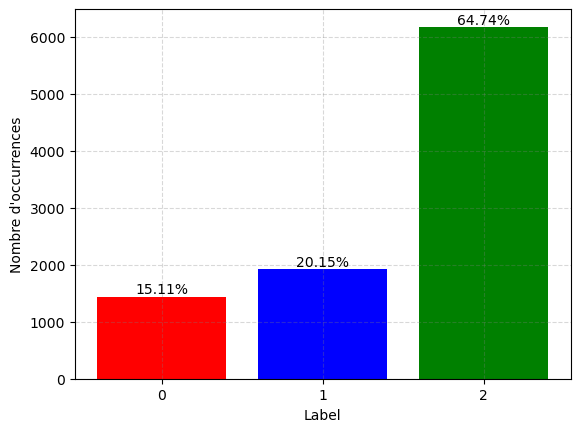

In [55]:
# Calcul du nombre d'occurrences et des proportions pour chaque label, triés par ordre croissant
label_counts = data_tweets['label'].value_counts().sort_values(ascending=True)
label_proportions = data_tweets['label'].value_counts(normalize=True).sort_values(ascending=True)

# Définir des couleurs différentes pour chaque label (adapter la liste en fonction du nombre de labels)
couleurs = ['red', 'blue', 'green', 'orange']  

# Position des barres : 0, 1, 2, ...
positions = range(len(label_counts))

# Création du barplot
plt.bar(positions, label_counts.values, color=[couleurs[i] for i in range(len(label_counts))])

# Remplacer les indices par les labels sur l'axe des abscisses
plt.xticks(positions, label_counts.index)

# Affichage du pourcentage (uniquement) sur chaque barre
for i, count in enumerate(label_counts.values):
    proportion = label_proportions.iloc[i]
    plt.text(i, count, f"{proportion:.2%}", ha='center', va='bottom')

# Activation d'une grille avec lignes grises
plt.grid(True, color='grey', linestyle = '--', alpha = 0.3)

# Étiquetage des axes
plt.xlabel("Label")
plt.ylabel("Nombre d'occurrences")

# Affichage du graphique
plt.show()

Le graphique révèle une forte disparité dans la répartition des tweets, avec environ 65 % des messages appartenant à la classe 2, tandis que les classes 0 et 1 ne représentent que 15 % et 20 % respectivement.

In [50]:
# filtrer les tweets positifs
tweets_positifs = data_tweets[data_tweets['label'] == 1]

# filtrer les tweets neutres
tweets_neutres = data_tweets[data_tweets['label'] == 2]

# filtrer les tweets négatifs
tweets_negatifs = data_tweets[data_tweets['label'] == 0]


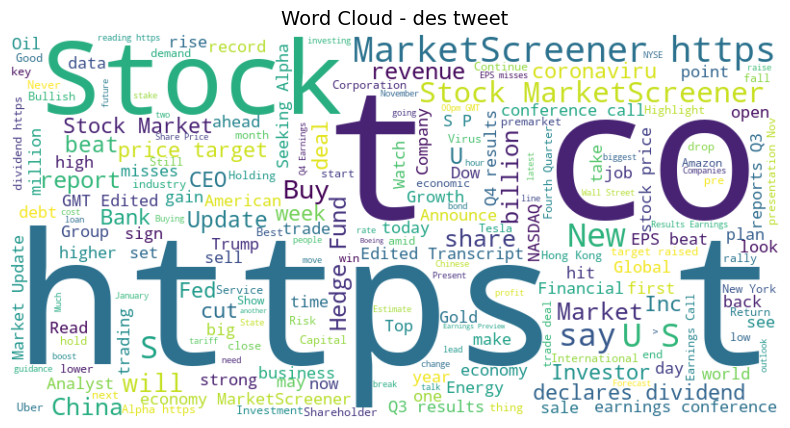

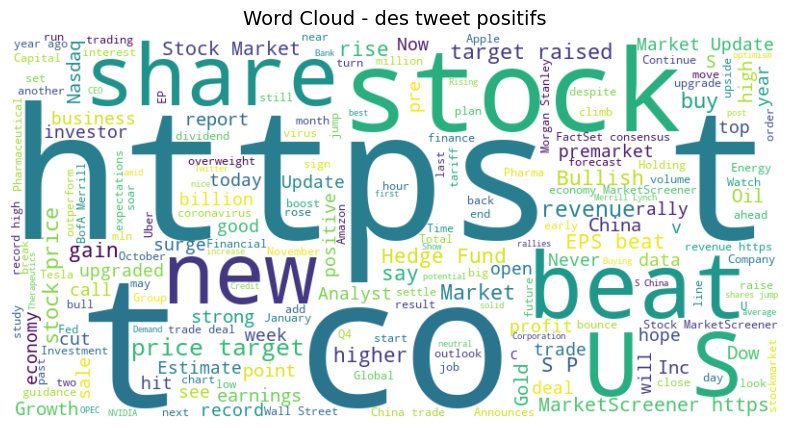

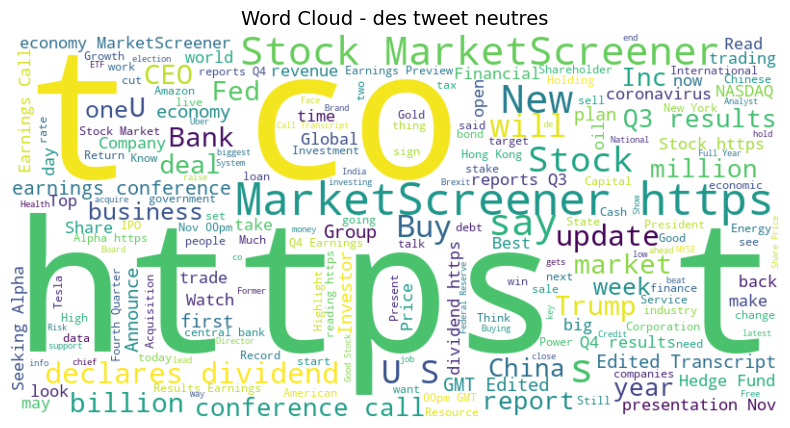

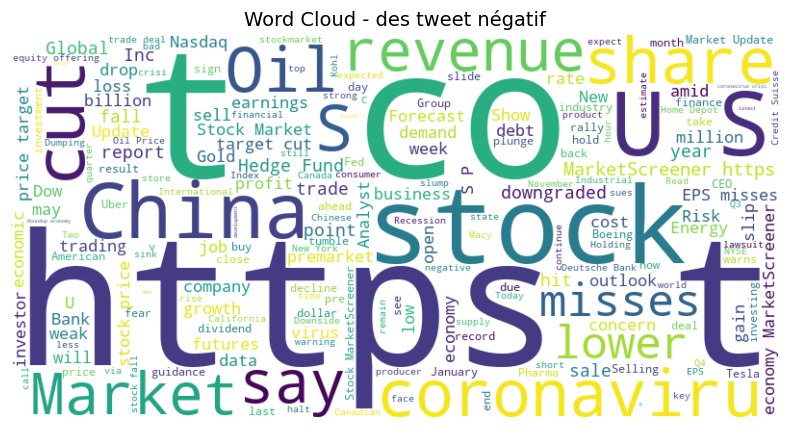

In [52]:

# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(data_tweets['text'], 'Word Cloud - des tweet')
generer_wordcloud(tweets_positifs['text'], 'Word Cloud - des tweet positifs')
generer_wordcloud(tweets_neutres['text'], 'Word Cloud - des tweet neutres')
generer_wordcloud(tweets_negatifs['text'], 'Word Cloud - des tweet négatif')

## Pre-processing tweets

In [58]:
nltk.download('wordnet') # Reducing words to their basic form
nltk.download('stopwords') 
nltk.download('punkt')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sodji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sodji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sodji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

***Stopwords*** are common words in a language that are often excluded from textual analysis because they don't provide much useful information. Examples include "the", "the", "and", "is", etc.

***Punkt*** is a tokenizer that is used to divide text into words, phrases, or other units of text. It is based on statistical models trained on large corpora of text.

In [60]:
def clean_text(text):
    # Removing special characters and punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Deleting URLs
    text = re.sub(r'http\S+', '', text)  
    
    # Convert to lowercase
    text = text.lower()
    
    # Text tokenization
    tokens = word_tokenize(text)
    
    # Removing stop words
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens in a single chain
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply text cleanup on the 'text' column
data_tweets['clean_text'] = data_tweets['text'].apply(clean_text)


In [62]:
data_tweets.head()

,text,label,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut


In [140]:
# Missing data
data_tweets.isnull().sum()

text          0
label         0
clean_text    0
dtype: int64

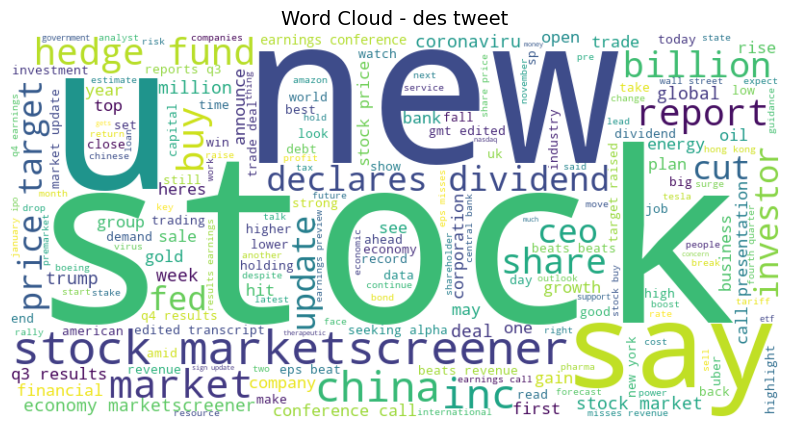

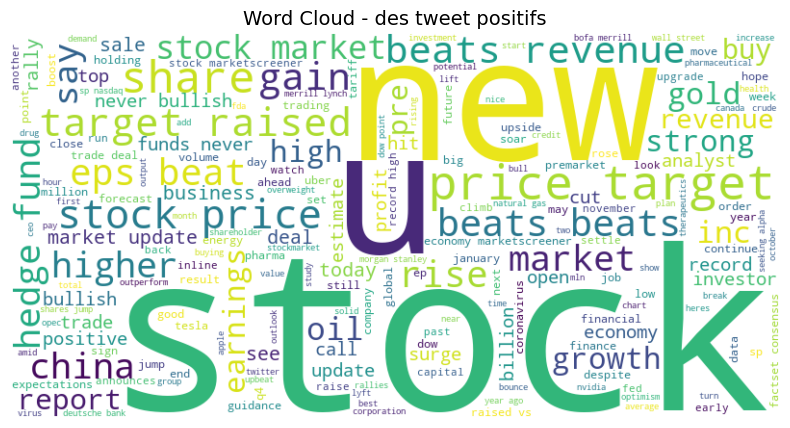

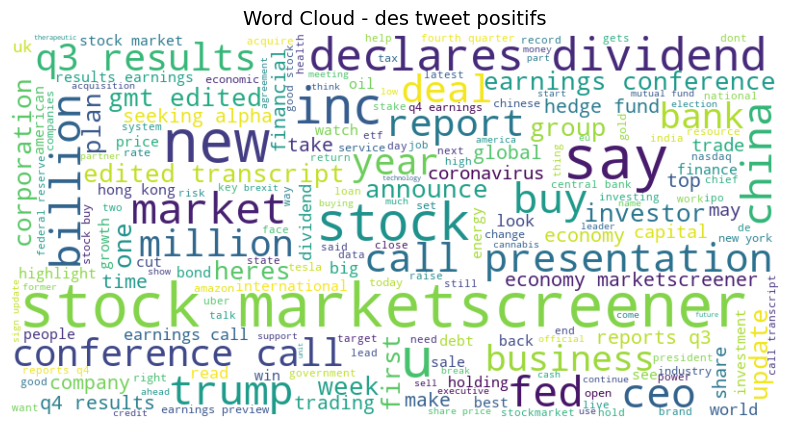

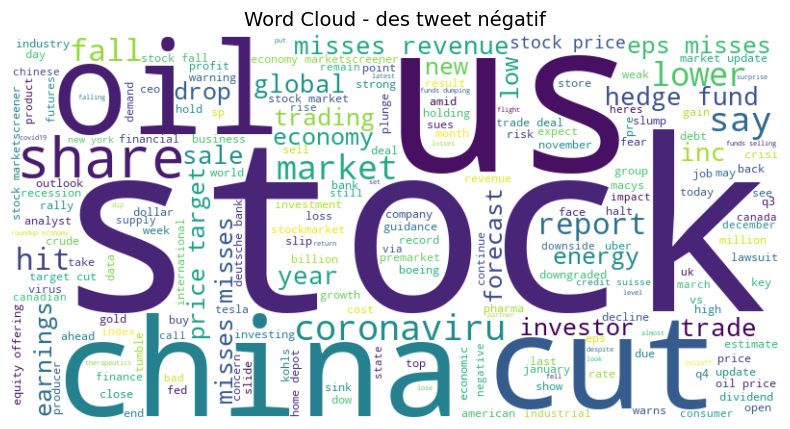

In [64]:
# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(data_tweets['clean_text'], 'Word Cloud - des tweet')
# Filtrer les tweets positifs
tweets_positifs = data_tweets[data_tweets['label'] == 1]['clean_text']
generer_wordcloud(tweets_positifs, 'Word Cloud - des tweet positifs')

# Filtrer les tweets neutres
tweets_neutres = data_tweets[data_tweets['label'] == 2]['clean_text']
generer_wordcloud(tweets_neutres, 'Word Cloud - des tweet positifs')


# Filtrer les tweets negatifs
tweets_negatifs = data_tweets[data_tweets['label'] == 0]['clean_text']
generer_wordcloud(tweets_negatifs, 'Word Cloud - des tweet négatif')

## 1 Implementing Algorithms

In [66]:
# Label transformation for binary classification: 0 (negative) vs 1 (positive/neutral)
data_tweets['label_binaire'] = data_tweets['label'].apply(lambda x: 0 if x == 0 else 1)
y_binary = data_tweets['label_binaire']

In [68]:
y_binary.unique()

array([0, 1], dtype=int64)

In [70]:
y_binary.value_counts()

label_binaire
1    8101
0    1442
Name: count, dtype: int64

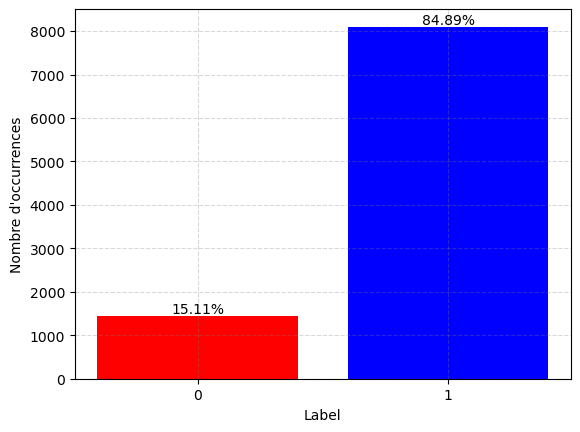

In [78]:
# Calcul du nombre d'occurrences et des proportions pour chaque label, triés par ordre croissant
label_counts = data_tweets['label_binaire'].value_counts().sort_values(ascending=True)
label_proportions = data_tweets['label_binaire'].value_counts(normalize=True).sort_values(ascending=True)

# Définir des couleurs différentes pour chaque label (adapter la liste en fonction du nombre de labels)
couleurs = ['red', 'blue', 'green']  

# Position des barres : 0, 1, 2, ...
positions = range(len(label_counts))

# Création du barplot
plt.bar(positions, label_counts.values, color=[couleurs[i] for i in range(len(label_counts))])

# Remplacer les indices par les labels sur l'axe des abscisses
plt.xticks(positions, label_counts.index)

# Affichage du pourcentage (uniquement) sur chaque barre
for i, count in enumerate(label_counts.values):
    proportion = label_proportions.iloc[i]
    plt.text(i, count, f"{proportion:.2%}", ha='center', va='bottom')

# Activation d'une grille avec lignes grises
plt.grid(True, color='grey', linestyle = '--', alpha = 0.3)

# Étiquetage des axes
plt.xlabel("Label")
plt.ylabel("Nombre d'occurrences")

# Affichage du graphique
plt.show()

## Modèles traditionnels avec TfidfVectorizer (Term Frequency-Inverse Document Frequency)

In [17]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_tweets['clean_text'], y_binary, test_size=0.2, random_state=42)
# Vectorisation des textes
vectorizer = TfidfVectorizer(max_features=5000)# meuilleur avec 5000
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [21]:
y_train.head()

5466    1
4180    1
5009    1
81      0
1323    0
Name: label_binaire, dtype: int64

In [23]:
len(X_train),len(X_test)

(7634, 1909)

In [25]:
X_train.head()

5466    teekay offshore partners lp q4 2019 earnings c...
4180    gs acquisition vertiv announcement call presen...
5009    nuveen amtfree quality municipal income fund d...
81          l brands stock price target cut 16 20 wedbush
1323    canada goose cuts forecast coronavirus impact ...
Name: clean_text, dtype: object

***Logistic Regression***

In [59]:
# Entraînement du modèle
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# Entraîner le modèle
start_time = time.time()

model_lr.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_lr = model_lr.predict(X_test_tfidf)

logistic_regression_time = time.time() - start_time
print(f"Logistic Regression Time: {logistic_regression_time:.2f} seconds")

# Évaluation correcte
print(classification_report(y_test, y_pred_lr))  

Logistic Regression Time: 0.23 seconds
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       300
           1       0.93      0.89      0.91      1609

    accuracy                           0.85      1909
   macro avg       0.73      0.77      0.75      1909
weighted avg       0.87      0.85      0.86      1909



In [63]:
# Afficher les hyperparamètres utilisés
print("Hyperparamètres :", model_lr.get_params())

Hyperparamètres : {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


***K-Nearest Neighbors***

In [71]:

knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')

start_time = time.time()
knn.fit(X_train_tfidf, y_train)

# Prédire sur l'ensemble de test
y_pred_kn = knn.predict(X_test_tfidf)

knn_time = time.time() - start_time
print(f"KNN Time: {knn_time:.2f} seconds")

# Évaluation correcte
print(classification_report(y_test, y_pred_kn))  

KNN Time: 0.46 seconds
              precision    recall  f1-score   support

           0       0.76      0.11      0.20       300
           1       0.86      0.99      0.92      1609

    accuracy                           0.85      1909
   macro avg       0.81      0.55      0.56      1909
weighted avg       0.84      0.85      0.81      1909



In [87]:
# Afficher les hyperparamètres utilisés
print("Hyperparamètres :", knn.get_params())

Hyperparamètres : {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


***Random Forest***

In [79]:
# Modèle
model_rf = RandomForestClassifier(n_estimators=500, random_state=42)

start_time = time.time()

# Entraîner le modèle
model_rf.fit(X_train_tfidf, y_train)

# Prédiction
y_pred_rf = model_rf.predict(X_test_tfidf)

random_forest_time = time.time() - start_time
print(f"Random Forest Time: {random_forest_time:.2f} seconds")

# Évaluation correcte
print(classification_report(y_test, y_pred_rf))  

Random Forest Time: 74.47 seconds
              precision    recall  f1-score   support

           0       0.77      0.36      0.49       300
           1       0.89      0.98      0.93      1609

    accuracy                           0.88      1909
   macro avg       0.83      0.67      0.71      1909
weighted avg       0.87      0.88      0.86      1909



In [89]:
# Afficher les hyperparamètres utilisés
print("Hyperparamètres :", model_rf.get_params())

Hyperparamètres : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Réseaux neuronaux

In [95]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Standardiser les données (important pour les réseaux de neurones)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

model_nn = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    max_iter=500,  # Plus d'itérations pour le modèle final
    activation='relu',
    solver='adam',
    random_state=42
)

start_time = time.time()
model_nn.fit(X_train_scaled, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_nn = model_nn.predict(X_test_scaled)

neural_network_time = time.time() - start_time
print(f"Neural Network Time: {neural_network_time:.2f} seconds")

# Évaluation correcte
print(classification_report(y_test, y_pred_nn))  

Neural Network Time: 69.23 seconds
              precision    recall  f1-score   support

           0       0.65      0.43      0.52       300
           1       0.90      0.96      0.93      1609

    accuracy                           0.87      1909
   macro avg       0.77      0.69      0.72      1909
weighted avg       0.86      0.87      0.86      1909



In [97]:
# Afficher les hyperparamètres utilisés
print("Hyperparamètres :", model_nn.get_params())

Hyperparamètres : {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


## Transformateurs models

In [99]:
data_tweets['text']

0       $BYND - JPMorgan reels in expectations on Beyo...
1       $CCL $RCL - Nomura points to bookings weakness...
2       $CX - Cemex cut at Credit Suisse, J.P. Morgan ...
3       $ESS: BTIG Research cuts to Neutral https://t....
4       $FNKO - Funko slides after Piper Jaffray PT cu...
                              ...                        
9538    The Week's Gainers and Losers on the Stoxx Eur...
9539    Tupperware Brands among consumer gainers; Unil...
9540    vTv Therapeutics leads healthcare gainers; Myo...
9541      WORK, XPO, PYX and AMKR among after hour movers
9542               YNDX, I, QD and OESX among tech movers
Name: text, Length: 9543, dtype: object

***Neural Networks(avec embeddings) - BiLSTM***

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


# Tokenisation et padding
print("\nPréparation des données pour le modèle BiLSTM...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Créer le modèle BiLSTM
print("\nCréation et entraînement du modèle BiLSTM...")
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiler et entraîner
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
start_time = time.time()

history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Évaluation
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

neural_network_time = time.time() - start_time
print(f"LSTM Time: {neural_network_time:.2f} seconds")


print("\n--- Évaluation du modèle BiLSTM ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909

Préparation des données pour le modèle BiLSTM...

Création et entraînement du modèle BiLSTM...


C:\Users\sodji\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - accuracy: 0.8494 - loss: 0.4685 - val_accuracy: 0.8613 - val_loss: 0.3482
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 319ms/step - accuracy: 0.8865 - loss: 0.2877 - val_accuracy: 0.8992 - val_loss: 0.2726
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 277ms/step - accuracy: 0.9488 - loss: 0.1441 - val_accuracy: 0.8940 - val_loss: 0.3002
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 306ms/step - accuracy: 0.9685 - loss: 0.0889 - val_accuracy: 0.8953 - val_loss: 0.3595
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.9853 - loss: 0.0498 - val_accuracy: 0.8927 - val_loss: 0.4488
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
LSTM Time: 181.46 seconds

--- Évaluation du modèle BiLSTM ---
Accuracy: 0.8852802514405448

Matrice de confusion:
[[ 152  148]
 [  71 1538]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       300
           1       0.91      0.

In [115]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)             │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,352,773 (8.98 MB)

 Trainable params: 784,257 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,568,516 (5.98 MB)

## Transformers (BERT)

In [ ]:
# https://huggingface.co/transformers/v3.2.0/custom_datasets.html

In [13]:
#!pip install transformers -U

In [66]:
# Data

#data_tweets = pd.read_excel('data_tweets2.xlsx')
#data_tweets['label_binaire'] = data_tweets['label'].apply(lambda x: 0 if x == 0 else 1)
#y_binary = data_tweets['label_binaire']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisation des données
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convertir en format PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, list(y_train))
test_dataset = SentimentDataset(test_encodings, list(y_test))

# Charger le modèle pré-entraîné BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Définir la fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculer l'accuracy
    accuracy = accuracy_score(labels, predictions)

    # Vous pouvez ajouter d'autres métriques ici si nécessaire
    return {
        'accuracy': accuracy
    }

# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results22',          # Dossier de sortie
    num_train_epochs=3,              # Nombre d'époques
    per_device_train_batch_size=16,  # Taille du batch
    per_device_eval_batch_size=64,   # Taille du batch pour l'évaluation
    warmup_steps=500,                # Nombre de warmup steps
    weight_decay=0.01,               # Décroissance du poids
    logging_dir='./logs2',            # Dossier pour les logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Évaluer à chaque époque
    save_strategy="epoch",           # Sauvegarder à chaque époque
)

# Entraîner le modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # Ajout de la fonction de calcul des métriques
)

print("\nEntraînement du modèle BERT...")
trainer.train()

# Évaluer le modèle
print("\n--- Évaluation du modèle BERT ---")
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']}")

# Faire des prédictions sur l'ensemble de test
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Matrice de confusion et rapport de classification
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))



Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.280000,0.273179,0.909900
2,0.078900,0.242140,0.925092
3,0.066300,0.262121,0.934521



--- Évaluation du modèle BERT ---


Accuracy: 0.9345206914614982

Matrice de confusion:
[[ 222   78]
 [  47 1562]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       300
           1       0.95      0.97      0.96      1609

    accuracy                           0.93      1909
   macro avg       0.89      0.86      0.87      1909
weighted avg       0.93      0.93      0.93      1909



## Model Optimization

### 2.1 Selection of Explanatory Variables

## Transformers (BERT)


Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909

----- Expérience avec max_length = 32 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.200000,0.226073,0.907805,0.902528
2,0.087500,0.275560,0.922472,0.922045
3,0.082600,0.316074,0.923520,0.923416


max_length: 32 | Accuracy: 0.9235 | F1: 0.9234 | Taux d'erreur: 0.0765 | Temps: 3543.25 sec

----- Expérience avec max_length = 64 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.203000,0.211523,0.915139,0.911643
2,0.068000,0.236585,0.927711,0.926472
3,0.052100,0.327219,0.928235,0.927377


max_length: 64 | Accuracy: 0.9282 | F1: 0.9274 | Taux d'erreur: 0.0718 | Temps: 6346.34 sec

----- Expérience avec max_length = 128 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262100,0.230423,0.912520,0.908071
2,0.054600,0.241697,0.927711,0.926688
3,0.057300,0.303588,0.931902,0.930837


max_length: 128 | Accuracy: 0.9319 | F1: 0.9308 | Taux d'erreur: 0.0681 | Temps: 7431.37 sec

----- Expérience avec max_length = 256 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262100,0.230423,0.912520,0.908071
2,0.054600,0.241697,0.927711,0.926688
3,0.057300,0.303588,0.931902,0.930837


max_length: 256 | Accuracy: 0.9319 | F1: 0.9308 | Taux d'erreur: 0.0681 | Temps: 7484.10 sec

----- Expérience avec max_length = 384 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262100,0.230423,0.912520,0.908071
2,0.054600,0.241697,0.927711,0.926688
3,0.057300,0.303588,0.931902,0.930837


max_length: 384 | Accuracy: 0.9319 | F1: 0.9308 | Taux d'erreur: 0.0681 | Temps: 7503.13 sec

----- Expérience avec max_length = 512 -----


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262100,0.230423,0.912520,0.908071
2,0.054600,0.241697,0.927711,0.926688
3,0.057300,0.303588,0.931902,0.930837


max_length: 512 | Accuracy: 0.9319 | F1: 0.9308 | Taux d'erreur: 0.0681 | Temps: 7916.03 sec

Résumé des expériences:
   max_length  accuracy        f1  error_rate  training_time
0          32  0.923520  0.923416    0.076480    3543.247911
1          64  0.928235  0.927377    0.071765    6346.341793
2         128  0.931902  0.930837    0.068098    7431.370387
3         256  0.931902  0.930837    0.068098    7484.103199
4         384  0.931902  0.930837    0.068098    7503.126205
5         512  0.931902  0.930837    0.068098    7916.026987


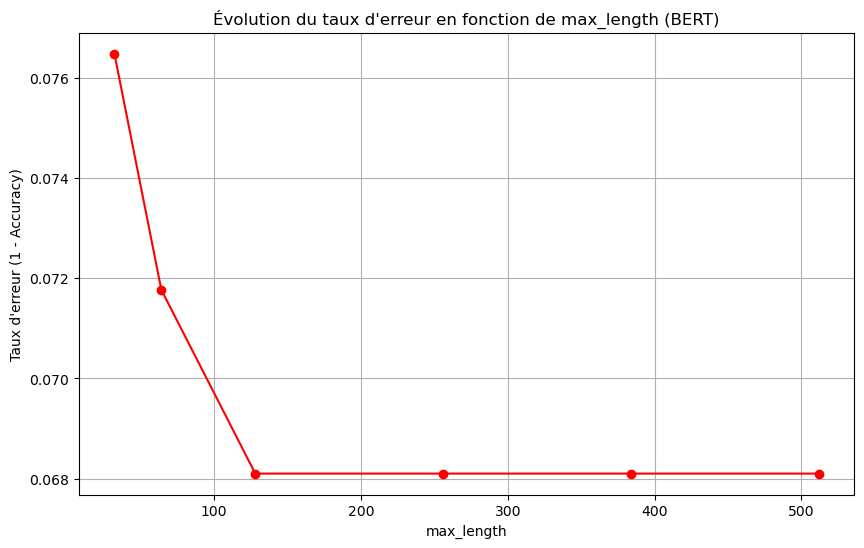

In [19]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# Définition de la classe de Dataset pour PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Fonction de calcul des métriques (accuracy et f1_score pondéré)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

# Liste étendue des valeurs de max_length à tester
max_length_list = [32, 64, 128, 256, 384, 512]
results = []

# Pour chaque valeur de max_length, on entraine et évalue le modèle BERT
for max_length in max_length_list:
    print(f"\n----- Expérience avec max_length = {max_length} -----")
    
    # Charger le tokenizer BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Tokenisation des données
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)
    
    # Conversion en format PyTorch
    train_dataset = SentimentDataset(train_encodings, list(y_train))
    test_dataset = SentimentDataset(test_encodings, list(y_test))
    
    # Charger le modèle BERT pour la classification (2 labels)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    
    # Définir les arguments d'entraînement
    training_args = TrainingArguments(
        output_dir=f'./results_{max_length}',  # Dossier de sortie spécifique
        num_train_epochs=3,                      # Pour la démonstration, 2 époques
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'./logs_{max_length}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
    )
    
    # Initialiser le Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
    # Mesurer le temps d'entraînement
    start_time = time.time()
    print("Entraînement du modèle BERT...")
    trainer.train()
    training_time = time.time() - start_time
    
    # Évaluation du modèle
    eval_results = trainer.evaluate()
    accuracy = eval_results.get('eval_accuracy')
    f1 = eval_results.get('eval_f1')
    error_rate = 1 - accuracy
    
    results.append({
        'max_length': max_length, 
        'accuracy': accuracy, 
        'f1': f1, 
        'error_rate': error_rate, 
        'training_time': training_time
    })
    print(f"max_length: {max_length} | Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Taux d'erreur: {error_rate:.4f} | Temps: {training_time:.2f} sec")

# Conversion des résultats en DataFrame pour l'analyse
results_df = pd.DataFrame(results)
print("\nRésumé des expériences:")
print(results_df)

# Tracé de l'évolution du taux d'erreur en fonction de max_length
plt.figure(figsize=(10,6))
plt.plot(results_df['max_length'], results_df['error_rate'], marker='o', color='red')
plt.xlabel('max_length')
plt.ylabel("Taux d'erreur (1 - Accuracy)")
plt.title("Évolution du taux d'erreur en fonction de max_length (BERT)")
plt.grid(True)
plt.show()

### The optimal length of text sequences after tokenization ‘max_length’ for the BERT model is 128

## 2.2 Selection of Hyperparameters

## BiLSTM model


Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909

Préparation des données pour le modèle BiLSTM...

--- Variation de la dimension d'embedding ---


C:\Users\sodji\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Embedding Dim: 64 => Taux d'erreur: 0.1341, Test Accuracy: 0.8659
Embedding Dim: 128 => Taux d'erreur: 0.1304, Test Accuracy: 0.8696
Embedding Dim: 256 => Taux d'erreur: 0.1420, Test Accuracy: 0.8580
   embedding_dim  error_rate  accuracy       Temps
0             64    0.134102  0.865898  110.988622
1            128    0.130435  0.869565  110.756246
2            256    0.141959  0.858041  123.180208
Le meuilleur output_dim est : 128

--- Variation du taux de Dropout ---


C:\Users\sodji\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Dropout Rate: 0.2 => Taux d'erreur: 0.1435, Test Accuracy: 0.8565
Dropout Rate: 0.5 => Taux d'erreur: 0.1304, Test Accuracy: 0.8696
Dropout Rate: 0.8 => Taux d'erreur: 0.1315, Test Accuracy: 0.8685
   dropout_rate  error_rate  accuracy       Temps
0           0.2    0.143531  0.856469  103.581559
1           0.5    0.130435  0.869565  107.831322
2           0.8    0.131482  0.868518  105.791181
Le meuilleur dropout est : 0.5

--- Variation du learning rate ---


C:\Users\sodji\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Learning Rate: 0.0001 => Taux d'erreur: 0.1383, Test Accuracy: 0.8617
Learning Rate: 0.001 => Taux d'erreur: 0.1456, Test Accuracy: 0.8544
Learning Rate: 0.01 => Taux d'erreur: 0.1372, Test Accuracy: 0.8628
   learning_rate  error_rate  accuracy       Temps
0         0.0001    0.138292  0.861708  155.371292
1         0.0010    0.145626  0.854374  199.878524
2         0.0100    0.137245  0.862755  189.369737
Le meuilleur learning_rate est : 0.01


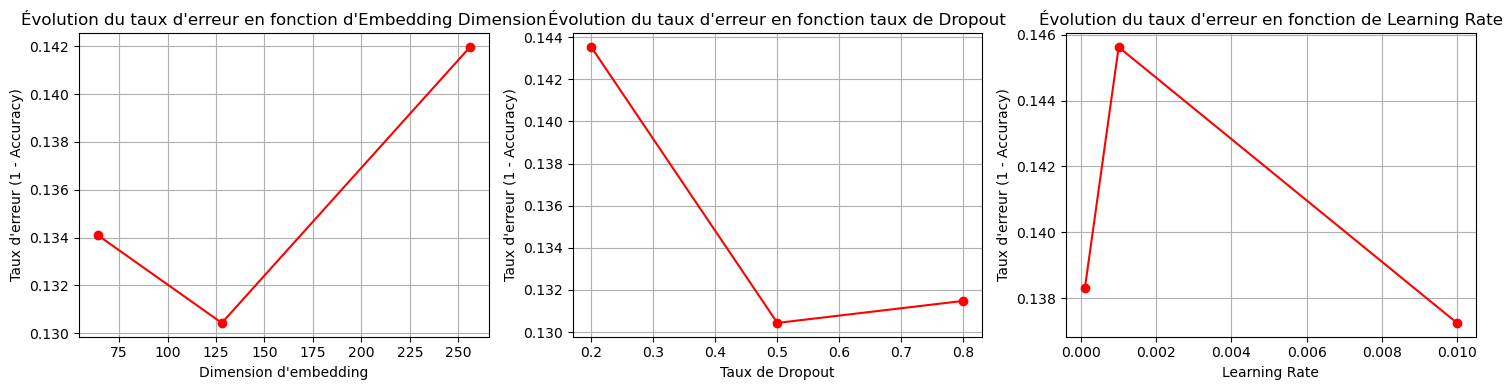

In [170]:

from tensorflow.keras.optimizers import Adam

# ------------------------------
# Préparation des données
# ------------------------------

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)
print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# Tokenisation et padding
print("\nPréparation des données pour le modèle BiLSTM...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# On fixe max_length à 100 pour ces expérimentations
max_length = 128
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# ------------------------------
# Fonction d'entraînement et évaluation
# ------------------------------

def run_experiment(embedding_dim, dropout_rate, learning_rate, 
                   max_length=128, epochs=5, batch_size=64, verbose=0):
    """
    Construit, compile et entraîne le modèle BiLSTM avec les hyperparamètres spécifiés.
    Renvoie le test loss, test accuracy et l'historique d'entraînement.
    """
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim = embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()

    history = model.fit(X_train_pad, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        verbose=verbose)
    
    loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
    m_time = time.time() - start_time
    
    return m_time, loss, accuracy, history

# ------------------------------
# 1. Variation de la dimension d'embedding
# ------------------------------

embedding_dims = [64, 128, 256]
results_embed = []

print("\n--- Variation de la dimension d'embedding ---")
for ed in embedding_dims:
    m_time, loss, acc, _ = run_experiment(embedding_dim=ed, dropout_rate=0.5, learning_rate=0.001, verbose=0)
    results_embed.append({'embedding_dim': ed, 'error_rate': 1-acc, 'accuracy': acc, 'Temps': m_time})
    print(f"Embedding Dim: {ed} => Taux d'erreur: {1-acc:.4f}, Test Accuracy: {acc:.4f}")

results_embed_df = pd.DataFrame(results_embed)

print(results_embed_df)

# Trouver l'indice de la ligne ayant l'erreur minimale
indice_min_embed = results_embed_df['error_rate'].idxmin()

best_embed = results_embed_df.loc[indice_min_embed, 'embedding_dim']

print(f"Le meuilleur output_dim est : {best_embed}")

# ------------------------------
# 2. Variation du taux de Dropout
# ------------------------------

dropout_rates = [0.2, 0.5, 0.8]
results_dropout = []

print("\n--- Variation du taux de Dropout ---")
for dr in dropout_rates:
    m_time, loss, acc, _ = run_experiment(embedding_dim=best_embed, dropout_rate=dr, learning_rate=0.001, verbose=0)
    results_dropout.append({'dropout_rate': dr, 'error_rate': 1-acc, 'accuracy': acc, 'Temps': m_time})
    print(f"Dropout Rate: {dr} => Taux d'erreur: {1-acc:.4f}, Test Accuracy: {acc:.4f}")

results_dropout_df = pd.DataFrame(results_dropout)

print(results_dropout_df)

# Trouver l'indice de la ligne ayant l'erreur minimale
indice_min_dropout = results_dropout_df['error_rate'].idxmin()

best_dropout = results_dropout_df.loc[indice_min_dropout, 'dropout_rate']

print(f"Le meuilleur dropout est : {best_dropout}")

# ------------------------------
# 3. Variation du learning rate
# ------------------------------

learning_rates = [0.0001, 0.001, 0.01]
results_lr = []

print("\n--- Variation du learning rate ---")
for lr in learning_rates:
    m_time, loss, acc, _ = run_experiment(embedding_dim=128, dropout_rate=0.5, learning_rate=lr, verbose=0)
    results_lr.append({'learning_rate': lr, 'error_rate': 1-acc, 'accuracy': acc, 'Temps': m_time})
    print(f"Learning Rate: {lr} => Taux d'erreur: {1-acc:.4f}, Test Accuracy: {acc:.4f}")

results_lr_df = pd.DataFrame(results_lr)
print(results_lr_df)


# Trouver l'indice de la ligne ayant l'erreur minimale
indice_min_lr = results_lr_df['error_rate'].idxmin()

# Récupérer le temps associé à cette erreur minimale
best_lr = results_lr_df.loc[indice_min_lr, 'learning_rate']

print(f"Le meuilleur learning_rate est : {best_lr}")


# ------------------------------
# Visualisation des résultats
# ------------------------------

plt.figure(figsize=(15, 4))

# Graphique pour la dimension d'embedding
plt.subplot(1, 3, 1)
plt.plot(results_embed_df['embedding_dim'], results_embed_df['error_rate'], marker='o', color='red')
plt.xlabel('Dimension d\'embedding')
plt.ylabel("Taux d'erreur (1 - Accuracy)")
plt.title("Évolution du taux d'erreur en fonction d'Embedding Dimension")
plt.grid(True)

# Graphique pour le taux de Dropout
plt.subplot(1, 3, 2)
plt.plot(results_dropout_df['dropout_rate'], results_dropout_df['error_rate'], marker='o', color='red')
plt.xlabel('Taux de Dropout')
plt.ylabel("Taux d'erreur (1 - Accuracy)")
plt.title("Évolution du taux d'erreur en fonction taux de Dropout")
plt.grid(True)

# Graphique pour le learning rate
plt.subplot(1, 3, 3)
plt.plot(results_lr_df['learning_rate'], results_lr_df['error_rate'], marker='o', color='red')
plt.xlabel('Learning Rate')
plt.ylabel("Taux d'erreur (1 - Accuracy)")
plt.title("Évolution du taux d'erreur en fonction de Learning Rate")
plt.grid(True)

plt.tight_layout()
plt.show()


## Transformers (BERT) model


Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909

----- Entraînement avec learning_rate = 1e-05 -----


C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.253000,0.250963,0.904662,0.898301
2,0.151000,0.223547,0.919853,0.916064
3,0.154900,0.253570,0.924568,0.923388


learning_rate: 1e-05 | Accuracy: 0.9246 | F1: 0.9234 | Taux d'erreur: 0.0754 | Temps: 7451.95 sec

----- Entraînement avec learning_rate = 2e-05 -----


C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.267600,0.225817,0.914615,0.908835
2,0.107600,0.211876,0.926663,0.923642
3,0.128300,0.282956,0.929806,0.928391


learning_rate: 2e-05 | Accuracy: 0.9298 | F1: 0.9284 | Taux d'erreur: 0.0702 | Temps: 7431.53 sec

----- Entraînement avec learning_rate = 3e-05 -----


C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.233200,0.257992,0.905186,0.892369
2,0.076000,0.220886,0.926663,0.925625
3,0.077100,0.294987,0.932425,0.932100


learning_rate: 3e-05 | Accuracy: 0.9324 | F1: 0.9321 | Taux d'erreur: 0.0676 | Temps: 7373.63 sec

----- Entraînement avec learning_rate = 5e-05 -----


C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262100,0.230423,0.912520,0.908071
2,0.054600,0.241697,0.927711,0.926688
3,0.057300,0.303588,0.931902,0.930837


learning_rate: 5e-05 | Accuracy: 0.9319 | F1: 0.9308 | Taux d'erreur: 0.0681 | Temps: 7736.78 sec

Résumé des expériences:
   learning_rate  accuracy        f1  error_rate       m_time
0        0.00001  0.924568  0.923388    0.075432  7451.951593
1        0.00002  0.929806  0.928391    0.070194  7431.529546
2        0.00003  0.932425  0.932100    0.067575  7373.630015
3        0.00005  0.931902  0.930837    0.068098  7736.775594


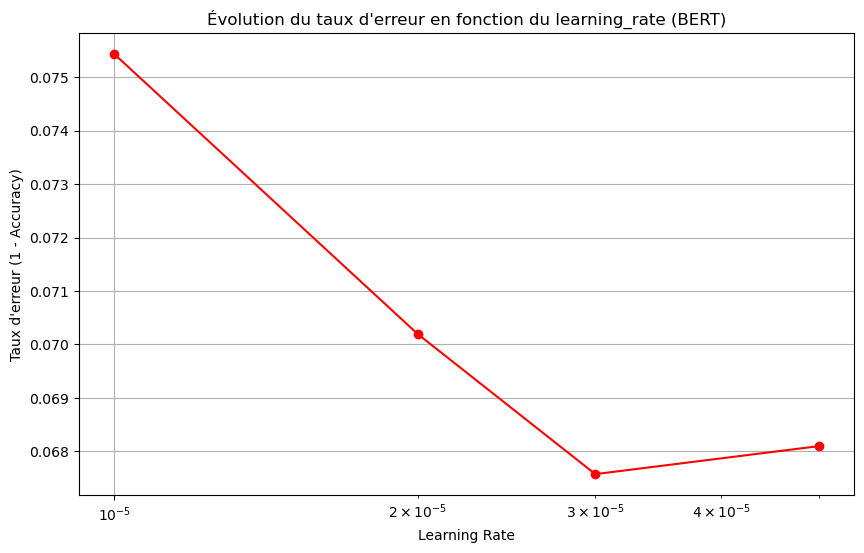

In [131]:

X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)
print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# Classe Dataset pour PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Fonction de calcul des métriques (accuracy et f1_score pondéré)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# On fixe une valeur de max_length pour la tokenisation
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)
train_dataset = SentimentDataset(train_encodings, list(y_train))
test_dataset = SentimentDataset(test_encodings, list(y_test))

# Liste des taux d'apprentissage à tester
learning_rate_list = [1e-5, 2e-5, 3e-5, 5e-5]
results_lr = []

for lr in learning_rate_list:
    print(f"\n----- Entraînement avec learning_rate = {lr} -----")
    
    # Définir les arguments d'entraînement avec le learning_rate courant
    training_args = TrainingArguments(
        output_dir=f'./results_lr_{lr}',
        num_train_epochs=3,                      # On utilise 2 époques pour la démonstration
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'./logs_lr_{lr}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
    )
    
    # Charger le modèle BERT pré-entraîné pour la classification (2 labels)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    
    # Initialiser le Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
    # Mesurer le temps d'entraînement
    start_time = time.time()
    print("Entraînement du modèle BERT...")
    trainer.train()
    
    # Évaluer le modèle
    eval_results = trainer.evaluate()

    m_time = time.time() - start_time
    
    accuracy = eval_results.get('eval_accuracy')
    f1 = eval_results.get('eval_f1')
    error_rate = 1 - accuracy
    
    results_lr.append({
        'learning_rate': lr,
        'accuracy': accuracy,
        'f1': f1,
        'error_rate': error_rate,
        'm_time': m_time
    })
    
    print(f"learning_rate: {lr} | Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Taux d'erreur: {error_rate:.4f} | Temps: {m_time:.2f} sec")

# Convertir les résultats en DataFrame pour l'analyse
results_df_lr = pd.DataFrame(results_lr)
print("\nRésumé des expériences:")
print(results_df_lr)

# Tracé de l'évolution du taux d'erreur en fonction du learning_rate
plt.figure(figsize=(10,6))
plt.plot(results_df_lr['learning_rate'], results_df_lr['error_rate'], marker='o', color='red')
plt.xlabel('Learning Rate')
plt.ylabel("Taux d'erreur (1 - Accuracy)")
plt.title("Évolution du taux d'erreur en fonction du learning_rate (BERT)")
plt.xscale('log')  # Pour mieux visualiser sur une échelle logarithmique
plt.grid(True)
plt.show()

## Grading Criterion 3: Selection and Evaluation of the Best Performing Model 


Taille de l'ensemble d'entraînement : 7634
Taille de l'ensemble de test : 1909

Préparation des données pour le modèle BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sodji\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Entraînement du modèle BERT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.244100,0.270844,0.898900
2,0.105100,0.204709,0.930854
3,0.060500,0.275527,0.930330



--- Évaluation du modèle BERT ---


Temps total : 8176.32 secondes
Accuracy: 0.930330015715034

Matrice de confusion:
[[ 227   73]
 [  60 1549]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       300
           1       0.95      0.96      0.96      1609

    accuracy                           0.93      1909
   macro avg       0.87      0.86      0.87      1909
weighted avg       0.93      0.93      0.93      1909

Modèle et tokenizer sauvegardés dans le dossier ./saved_best_bert_model


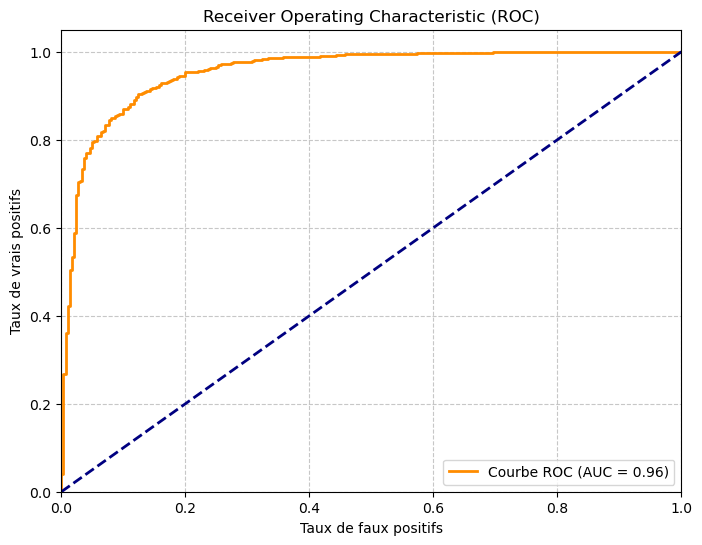

In [134]:
#import time
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import torch
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
#from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

# ------------------------------
# Chargement et préparation des données
# ------------------------------
# Remarque : Décommentez et ajustez la lecture du fichier si besoin.
# data_tweets = pd.read_excel('data_tweets2.xlsx')
# data_tweets['label_binaire'] = data_tweets['label'].apply(lambda x: 0 if x == 0 else 1)
# y_binary = data_tweets['label_binaire']

# Ici, on suppose que data_tweets et y_binary existent déjà.
X_train, X_test, y_train, y_test = train_test_split(data_tweets['text'], y_binary, test_size=0.2, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# ------------------------------
# Tokenisation avec BERT
# ------------------------------
print("\nPréparation des données pour le modèle BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisation avec troncature et padding (max_length fixé à 128)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# ------------------------------
# Création d'un Dataset PyTorch personnalisé
# ------------------------------
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, list(y_train))
test_dataset = SentimentDataset(test_encodings, list(y_test))

# ------------------------------
# Chargement du modèle BERT pré-entraîné pour la classification
# ------------------------------
best_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# ------------------------------
# Définition de la fonction de calcul des métriques
# ------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# ------------------------------
# Définition des arguments d'entraînement
# ------------------------------
training_args = TrainingArguments(
    output_dir='./results22_best',          # Dossier de sortie
    num_train_epochs=3,                # Nombre d'époques
    per_device_train_batch_size=16,    # Taille du batch d'entraînement
    per_device_eval_batch_size=64,     # Taille du batch pour l'évaluation
    learning_rate=3e-5,
    warmup_steps=500,                  # Nombre de warmup steps
    weight_decay=0.01,                 # Décroissance du poids
    logging_dir='./logs2_best',             # Dossier pour les logs
    logging_steps=10,
    evaluation_strategy="epoch",       # Évaluer à chaque époque
    save_strategy="epoch",             # Sauvegarder à chaque époque
)

# ------------------------------
# Entraînement du modèle avec Trainer
# ------------------------------
trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("\nEntraînement du modèle BERT...")
start_time = time.time()
trainer.train()

# ------------------------------
# Évaluation du modèle
# ------------------------------
print("\n--- Évaluation du modèle BERT ---")
results = trainer.evaluate()
m_time = time.time() - start_time
print(f"Temps total : {m_time:.2f} secondes")
print(f"Accuracy: {results['eval_accuracy']}")

# Prédictions sur l'ensemble de test
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


# Sauvegarder le modèle entraîné et le tokenizer dans le dossier "./saved_bert_model"
model_dir = "./saved_best_bert_model"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"Modèle et tokenizer sauvegardés dans le dossier {model_dir}")

# ------------------------------
# Tracé de la courbe ROC
# ------------------------------
# Les logits obtenus contiennent les scores pour chacune des 2 classes.
logits = predictions.predictions

# Conversion en probabilités via la fonction softmax
probas = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
# Probabilités pour la classe positive (label 1)
y_score = probas[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [174]:
best_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Pourquoi avons-nous choisi le modèle BERT ?

Nous avons choisi **BERT** (Bidirectional Encoder Representations from Transformers) car il est le modèle le plus performant parmi ceux que nous avons entraînés. Pré-entraîné sur de nombreuses données, BERT excelle à capturer le contexte linguistique.

**Hyperparamètres choisis :**

- Nombre d’époques (***num_train_epochs=3***) : 3 époques pour éviter le sur-apprentissage tout en permettant la convergence.
- Taille du batch d’entraînement (***per_device_train_batch_size=16***) : 16 pour un compromis entre stabilité et contraintes matérielles.
- Taille du batch d’évaluation (***per_device_eval_batch_size=64***) : 64 pour réduire le temps d’inférence tout en restant gérable en mémoire.
- Taux d’apprentissage (***learning_rate=3e-5***) : 3e-5 pour éviter la déstabilisation de l’entraînement.
- Warmup steps (***warmup_steps=500***) : Commencer avec un taux d’apprentissage faible pour stabiliser les gradients, puis l’augmenter progressivement.
- Weight decay (***weight_decay=0.01***) : Pénalisation légère sur les poids pour réduire le sur-apprentissage.

Les **variables explicatives** sont les tweets, convertis en tokens via le BertTokenizer. Ces tokens sont fournis à BERT, qui génère des embeddings contextuels pour chaque token et produit une représentation agrégée pour la classification finale du tweet.

Le **taux de classification correct** est d’environ ***0.93***, avec une F1 pondérée de ***0.93***, une précision générale de ***0.93***, et un rappel pondéré de ***0.93***, indiquant de très bonnes performances globales. Cependant, la classe négative est moins bien reconnue (rappel de 0.76), révélant un déséquilibre de classes et une difficulté à identifier les tweets négatifs.

Les **faiblesses** incluent le déséquilibre de classes, le coût computationnel, et la dépendance aux données de fine-tuning. Une collecte de données supplémentaires, un équilibrage des classes, ou un ajustement des hyperparamètres pourraient améliorer la détection des réponses négatives.

## 4 Grading Criterion 4: Ability to Learn Coding Independently 

## Logistique regression

***Méthodes de classification multiclasses (donc maintien de la variable d’étiquette avec trois classes) et validation croisée***

In [139]:
data_tweets.head()

,text,label,clean_text,label_binaire
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat,0
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,0
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut,0


In [141]:
data_tweets['label']

0       0
1       0
2       0
3       0
4       0
       ..
9538    2
9539    2
9540    2
9541    2
9542    2
Name: label, Length: 9543, dtype: int64

In [145]:
data_tweets['label'].unique()

array([0, 1, 2], dtype=int64)

Scores de validation croisée (accuracy) :  [0.77603143 0.76096922 0.76882777 0.78519974 0.75294889]
Score moyen de validation croisée : 76.88%
Temps d'entraînement : 0.23 secondes

Rapport de classification sur le jeu de test :
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       300
           1       0.58      0.69      0.63       388
           2       0.87      0.81      0.84      1221

    accuracy                           0.75      1909
   macro avg       0.67      0.69      0.68      1909
weighted avg       0.76      0.75      0.75      1909



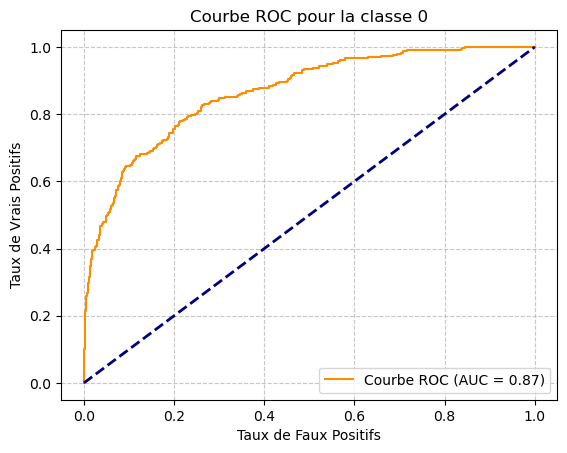

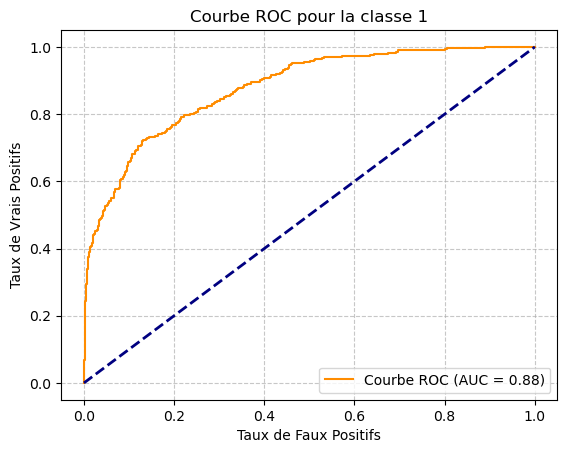

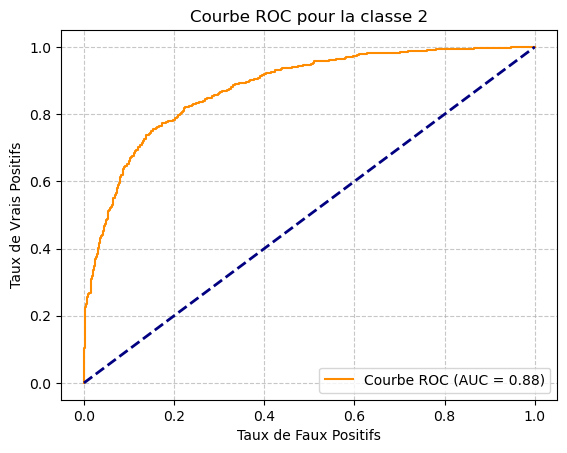

In [159]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import label_binarize

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_tweets['clean_text'], data_tweets['label'], test_size=0.2, random_state=42)
# Vectorisation des textes
vectorizer = TfidfVectorizer(max_features=5000)# meuilleur avec 5000
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Initialisation du modèle de régression logistique multiclasse
# Ici, 'multi_class' est mis à 'multinomial' pour le traitement multiclasse
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced',
                              multi_class='multinomial', solver='lbfgs')

# Validation croisée sur le jeu d'entraînement
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_lr, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
print("Scores de validation croisée (accuracy) : ", cv_scores)
print("Score moyen de validation croisée : {:.2f}%".format(cv_scores.mean() * 100))

# Entraînement du modèle sur le jeu d'entraînement et mesure du temps d'exécution
start_time = time.time()
model_lr.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time
print(f"Temps d'entraînement : {training_time:.2f} secondes")

# Prédictions sur le jeu de test
y_pred_lr = model_lr.predict(X_test_tfidf)
print("\nRapport de classification sur le jeu de test :")
print(classification_report(y_test, y_pred_lr))

# Calcul et affichage des courbes ROC pour chaque classe
# Pour un problème multiclasse, on calcule la courbe ROC en mode one-vs-all
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model_lr.predict_proba(X_test_tfidf)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'Courbe ROC (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle='--')
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title(f'Courbe ROC pour la classe {classes[i]}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
